### Predicting the locations with no prior knowledge

The aim is to predict the locations of the transducers purely based on the signal data. Necessary plots, prints and tables will be plotted. The user may change the parameters within the plots as per the instructions for exploratory analysis of their dataset. The final optimized parameters are at the end of the notebook. Two different possible parameters, are given along with 'which one is more probable'. The time taken to execute the notebook depends on the total number of sensors, typically ranging from 2-6 minutes. Some hyperparameters are tuned based on 'typical datasets' found in labratory works. These can be changed, if the user's setup differs significantly. Changable parameters, and the effect of change are given in the notebook.

#### Define these parameters

In [5]:
total_sensors = 8
transducer_name = 'V3RAUS'

## In meters
pipe_length = 0.3
thickness = 0.0045     ## Set to 0 if not known
pipe_diameter = 0.2191 

fs = 4e6   ## sampling frequency
max_helical_order = 4  ## no of helical paths taken into account

The folder should be in the same directory as this script. Folder should contain same number of files as there are transducers.
Each file should contain one transducer tramitting and all others (including the emitting one) receiving i.e., no of columns in each file should also be the same as total number of transducers. If the sensor data for transmitting sensor is not available, a dummy column of random values will be added, and masked during the optimization. 

In [7]:
data_folder = 'clean_dataset2/'

The model will detect the highest amplitude frequency and use that to extract the TOAs, provided that this frequency is constant (roughly) for the entire dataset.

#### Initial guess for velocity and time zero

Set the initial guess for group velocity and time zero. These are optimized, however better initialization leads to more accurate final predictions.

In [11]:
A0_group_velocity = 2800 # m/s  
t0 = 50/fs

#### Necessary imports

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import torch
import torch.nn as nn

from scipy.fft import rfft, rfftfreq
from scipy.signal import sosfiltfilt, sosfilt, cwt, hilbert, find_peaks, butter
from scipy.optimize import linear_sum_assignment
from helper2 import *

import torch.optim as optim

##### Masking instructions

- The dataset is converted into matrix of shape {total_sensor x total_sensors}
- where rows are transmitting and columns are receiving transducers
- Each value of a matrix is the first TOA for that tx-rx combination
- By default a diagonal mask is used (so same tx-rx pairs are masked)
- The user may use another mask manually, if certain paths are cut.  

In [16]:
diagonal_mask = ~torch.eye(total_sensors, dtype=torch.bool) 

#### Do not modify these parameters

In [18]:
## Do not modify these unless the setup differs significantly
pipe_circumference = pipe_diameter * np.pi
morlet_w = 9
pipe_diameter = pipe_diameter - thickness


mean_range = (50, 4000)
corr_range = (50, 700)

##### Data Handling

In [20]:
file_names = sorted([x for x in os.listdir(data_folder) if x.endswith('.tsv')])
print('Tx-Rx:\n', file_names)

Tx-Rx:
 ['RAUSmeasurement_2025-05-28T201808_V3RAUS1.tsv', 'RAUSmeasurement_2025-05-28T201808_V3RAUS2.tsv', 'RAUSmeasurement_2025-05-28T201808_V3RAUS3.tsv', 'RAUSmeasurement_2025-05-28T201808_V3RAUS4.tsv', 'RAUSmeasurement_2025-05-28T201808_V3RAUS5.tsv', 'RAUSmeasurement_2025-05-28T201808_V3RAUS6.tsv', 'RAUSmeasurement_2025-05-28T201808_V3RAUS7.tsv', 'RAUSmeasurement_2025-05-28T201808_V3RAUS8.tsv']


In [21]:
## Only for the first file. 
data_df = pd.read_csv(data_folder+file_names[0], delimiter='\t')
data_df.rename(columns = {'Unnamed: 0':'time'}, inplace = True)
data_df.set_index('time', inplace=True)
repetitions = data_df.groupby('time').size()[0]
signal_length = data_df.groupby('time').size().shape[0]

print('Identified {} repetitions of {} length'.format(repetitions, signal_length))

Identified 20 repetitions of 4000 length


All repetitions are alligned and averaged out.

In [23]:
d = {}

for file_name in file_names:
    file_path = os.path.join(data_folder, file_name)
    
    data_df = pd.read_csv(file_path, delimiter='\t')
    data_df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
    data_df.set_index('time', inplace=True)
    
    tx_name = file_name[-11:-4]  # keep your slicing as it is
    
    print('\n*** Doing: Tranmitter', tx_name)
    
    tmp, _, _, _ = correct_jitter(data_df, tx_name,
                                  mean_range=mean_range, 
                                  corr_range=corr_range, 
                                  repetitions=repetitions, 
                                  signal_length=signal_length)
    

    t_delay = 2 - np.argmax(tmp[tx_name].diff(1) < -10)
    tmp = tmp.shift(t_delay, fill_value=0)
    
    # Save the corrected data in dict d
    d['Tx-Rx', tmp.columns[0][:-1] + file_name[-5]] = pd.DataFrame(columns=tmp.columns, data=tmp)

# Combine all processed dataframes horizontally
data_df_corr_all = pd.concat(d, axis=1)


*** Doing: Tranmitter V3RAUS1

*** V3RAUS1 *** Reference lags: 
 [  0. -11.   7.  31. -14.  19. -37. -12.  38.   0. -37.   0.  -8.  33.
  -5.  -2.   0.   4.  10. -16.]

--- V3RAUS2 ---
 Max signal variation > 50% from mean or lag > 80 timesteps. Excluding those from mean...
Amps: 
 [22.22   1.872  0.563 -0.498  0.535 -0.75   0.541  0.995 -2.141 -1.209
 -0.108    nan -1.734 -3.036 -2.155 -2.438 -2.658 -3.364 -3.805 -2.831]
Mask: 
 [ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True]

--- V3RAUS3 ---
 Max signal variation > 50% from mean or lag > 80 timesteps. Excluding those from mean...
Amps: 
 [    nan -90.498  10.059     nan  10.643     nan  10.237  11.214   5.274
   7.366   8.873   6.514   6.671   4.414   5.806     nan     nan     nan
   3.428     nan]
Mask: 
 [False False  True False  True False  True  True  True  True  True  True
  True  True  True False False False  True False]

--- V3RAUS4 ---
 Max signal var

In [24]:
## Orders the dataframe
transducer_order = [f'{transducer_name}{i}' for i in range(1, total_sensors + 1)]
desired_columns = [
    ('Tx-Rx', tx, rx)
    for tx in transducer_order
    for rx in transducer_order
]
data_df_corr_all = data_df_corr_all.loc[:, desired_columns]
data_df_corr_all.shape

(4000, 64)

### Extracting first time of arrivals

The approach behind detecting first TOA is to extract 4 local maximas (max values sepearated by 150 samples) and take the first one
corresponding to first TOA. It is assumed that first TOA is atleast 40% of max value of the dataset.


#### CWT approach

Median frequency of the whole dataset is automatically inferred for further analysis. If you wish to change this, set the tx_freq
in Hz.

In [29]:
tx_freq = get_median_peak_frequency(data_df_corr_all, fs)

In [30]:
print(f"Median peak frequency: {tx_freq/1e3:.2f} kHz")
cwt_freq_range = (tx_freq-50e3, tx_freq+50e3)
freq_range = np.linspace(tx_freq-50e3,tx_freq+50e3, 101)
tx_freq_index = np.argmin(np.abs(freq_range - tx_freq))
t = np.arange(len(data_df_corr_all)) / fs

Median peak frequency: 195.00 kHz


In [31]:
group_size = data_df_corr_all.shape[1] // total_sensors
data_groups = {
    f"tx{i+1}": data_df_corr_all.iloc[:, i*group_size : (i+1)*group_size]
    for i in range(total_sensors)
}

Change the variable transmitter to access the amplitude frequency relationship of that transmitter.
tx1 denoting the plot for transmitter 1.

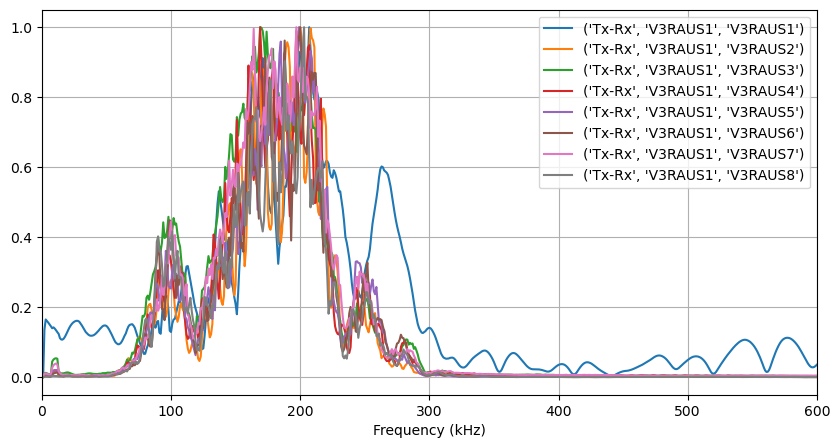

In [33]:
transmitter = 'tx1'
names = list(data_groups[transmitter].columns)
#selected_names = [names[i] for i in [0, 2, 7]
## Replace with above if you only want selected columns
print_data_freq(data_df=data_groups[transmitter].iloc[:4000],print_names=names,fs=fs,rolling=5)

In [34]:
cwt_toa_dict = {}

min_distance = 150  # minimum distance between peaks, adjusted graphically 
peak_height_threshold = 0.4  # relative threshold

for col in data_df_corr_all.columns:
    signal = data_df_corr_all[col]
    signal.name = col

    cwt = make_cwt(signal, fs=fs, freq_range=freq_range, w=morlet_w,
                   plot_cwt=False, plot_dispertion=False, t0=-t0)

    magnitude = np.abs(cwt)
    mag_1d = magnitude[tx_freq_index, :]

    # Normalize amplitude for thresholding
    mag_norm = mag_1d / np.max(mag_1d)

    # All peaks above threshold, separated by min_distance samples
    peaks, properties = find_peaks(mag_norm, height=peak_height_threshold, distance=min_distance)

    first_peak = peaks[:4][0]   ## if less than 4, take all
    toa_times = t[first_peak]
    cwt_toa_dict[col] = toa_times

cwt_toa_dict

{('Tx-Rx', 'V3RAUS1', 'V3RAUS1'): 7.25e-06,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS2'): 6.125e-05,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS3'): 0.000116,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS4'): 6.075e-05,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS5'): 0.00010275,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS6'): 0.000117,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS7'): 0.000153,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS8'): 0.0001175,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS1'): 6.175e-05,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS2'): 7.5e-06,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS3'): 6.15e-05,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS4'): 0.0001165,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS5'): 0.00011825,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS6'): 0.00010375,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS7'): 0.0001185,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS8'): 0.00015325,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS1'): 0.00011575,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS2'): 6.125e-05,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS3'): 7.5e-06,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS4'): 6.1e-05,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS5'): 0.00015225,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS6'): 0.00011775,
 ('Tx-Rx', 'V3

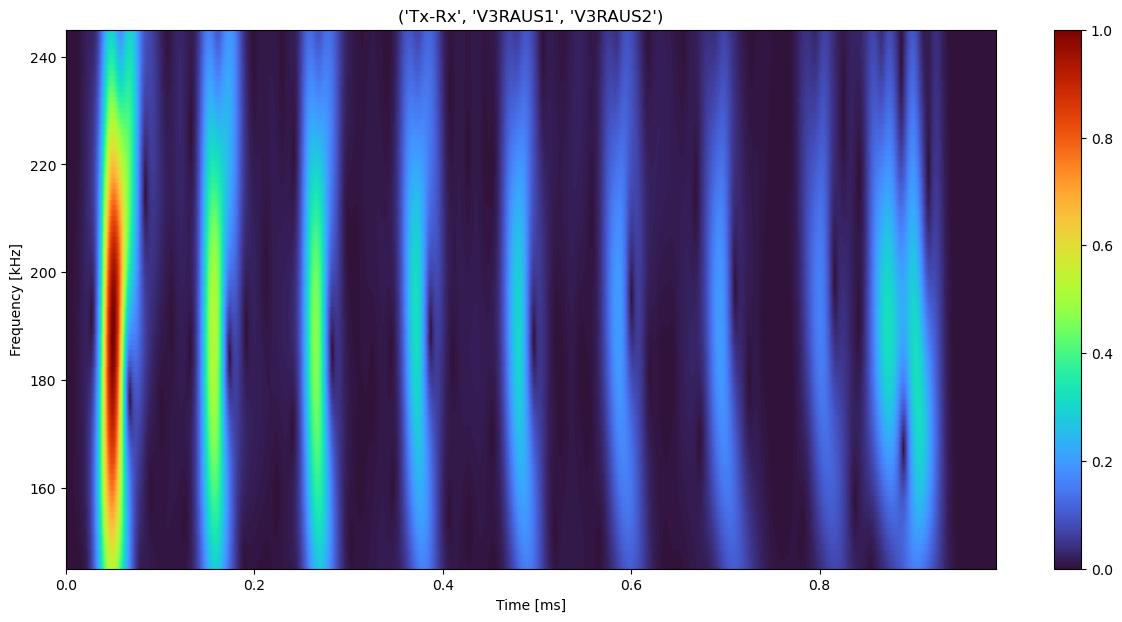

In [35]:
## Change tx, rx numbers to view different plots.
tx_number = 1
rx_number = 2

tx_name = f"{transducer_name}{tx_number}"
rx_name = f"{transducer_name}{rx_number}"

cwt_trial = make_cwt(data_df_corr_all[('Tx-Rx', tx_name, rx_name)], fs=fs, freq_range=cwt_freq_range, w=morlet_w, 
             plot_cwt=True, plot_dispertion=False, t0=-t0)

#### Filtering + Hilbert approach

In [37]:
filt = (tx_freq - 30e3, tx_freq + 30e3)
order = 10
sos = butter(order, filt, btype='bandpass', fs=fs, output='sos')

toa_dict_hilbert = {}

for col in data_df_corr_all.columns:
    signal = data_df_corr_all[col].values
    filtered_signal = sosfiltfilt(sos, signal)
    hill = np.abs(hilbert(filtered_signal))


    # Peaks in the Hilbert envelope
    peaks, properties = find_peaks(
        hill,
        height=np.max(hill) * 0.3,  # At least 30% of max
        distance=150                 # Minimum 150 samples apart
    )

    # First 4 peaks in time order 
    first_peak = peaks[:4][0]
    first_4_peak_times = t[first_peak]
    
    toa_dict_hilbert[col] = first_4_peak_times.tolist()

toa_dict_hilbert

{('Tx-Rx', 'V3RAUS1', 'V3RAUS1'): 1.9e-05,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS2'): 6.325e-05,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS3'): 0.00011525,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS4'): 6.225e-05,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS5'): 0.00010375,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS6'): 0.00011725,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS7'): 0.00015125,
 ('Tx-Rx', 'V3RAUS1', 'V3RAUS8'): 0.00011725,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS1'): 6.375e-05,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS2'): 2.025e-05,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS3'): 6.35e-05,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS4'): 0.000118,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS5'): 0.00011925,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS6'): 0.0001045,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS7'): 0.0001185,
 ('Tx-Rx', 'V3RAUS2', 'V3RAUS8'): 0.0001525,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS1'): 0.00011575,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS2'): 6.35e-05,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS3'): 2.05e-05,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS4'): 6.3e-05,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS5'): 0.00015175,
 ('Tx-Rx', 'V3RAUS3', 'V3RAUS6'): 0.00011775,
 ('Tx-Rx'

Selected signal: ('Tx-Rx', 'V3RAUS1', 'V3RAUS2')


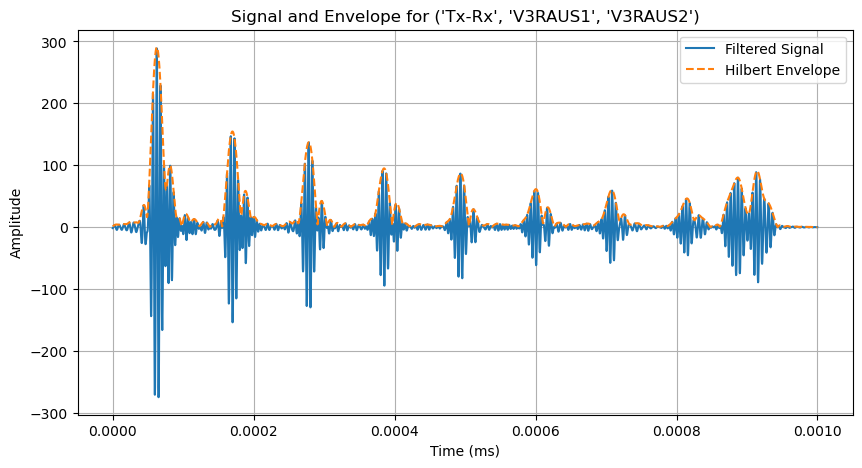

Peak envelope index: 250, time: 0.00006 s


In [38]:
## Should be between 1 and total sensors. Change transmitter and receiver numbers to view other plots.
transmitter_no = 1
receiver_no = 2


row_idx = transmitter_no -1
col_idx = receiver_no -1
signal_index = total_sensors * row_idx + col_idx


signal_name = data_df_corr_all.columns[signal_index]
print("Selected signal:", signal_name)

filt = (tx_freq - 50e3, tx_freq + 50e3)
sos = butter(10, filt, btype='bandpass', fs=fs, output='sos')


raw_signal = data_df_corr_all[signal_name].values[:]
filtered_signal = sosfiltfilt(sos, raw_signal)
envelope = np.abs(hilbert(filtered_signal))


plt.figure(figsize=(10,5))
plt.plot(t, filtered_signal, label='Filtered Signal')
plt.plot(t, envelope, '--', label='Hilbert Envelope')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title(f'Signal and Envelope for {signal_name}')
plt.legend()
plt.grid(True)
plt.show()

# Print peak envelope
peak_idx = np.argmax(envelope)
print(f'Peak envelope index: {peak_idx}, time: {t[peak_idx]:.5f} s')

To tensors:

In [40]:
hilbert_toa_df_all = convert_toa_dict_to_df(toa_dict_hilbert)
cwt_toa_df_all = convert_toa_dict_to_df(cwt_toa_dict)
hilbert_toa_df = convert_toa_dict_to_df(toa_dict_hilbert)
cwt_toa_df = convert_toa_dict_to_df(cwt_toa_dict)
hilbert_tensor = torch.tensor(hilbert_toa_df.values, dtype=torch.float32)
cwt_tensor = torch.tensor(cwt_toa_df.values, dtype=torch.float32)

### Optimization

In [42]:
### experimental toa, and time zero to ms
### group velocity to km/s
A0_group_velocity_kms =  A0_group_velocity/1000
time_zero_ms = t0 * 1e3
experimental_toa = cwt_tensor.float() * 1e3  

In [43]:
num_restarts = 20
mse_loss = torch.nn.MSELoss()

results_per_seed = []

for seed in range(num_restarts):
    torch.manual_seed(seed * 10)
    sensor_positions = torch.rand((total_sensors, 2)).float()
    sensor_positions[:, 0] *= pipe_length
    sensor_positions[:, 1] *= pipe_circumference
    sensor_positions[0] = 0  # Anchor sensor 0

    points = sensor_positions.clone().requires_grad_(True)
    v_group_init = torch.tensor(A0_group_velocity_kms, dtype=torch.float32, requires_grad=True)    
    initial_t0 = torch.tensor(time_zero_ms, dtype=torch.float32, requires_grad=True)                      
    
    optimizer = torch.optim.Adam([points, v_group_init, initial_t0], lr=0.01)

    loss_history = []
    for iteration in range(300):
        optimizer.zero_grad()
        distances = create_distance_matrix(points, max_order=max_helical_order, pipe_dia=pipe_diameter)[:, :, 0]
        simulated_toa = (distances / v_group_init) + initial_t0
        loss = mse_loss(simulated_toa[diagonal_mask], experimental_toa[diagonal_mask])
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        
        with torch.no_grad():
            points.data[0] = torch.tensor([0.0, 0.0])
            
    with torch.no_grad():
        points.data[:, 1] %= pipe_circumference

    results_per_seed.append({
        'seed': seed * 10,
        'final_loss': (loss.item() ** 0.5)*1e3,              ## square root of MSE loss stored (in seconds)
        'positions': points.detach().clone(),
        'v_group': v_group_init.item() * 1e3,
        't0': initial_t0.item() / 1e3,
        'loss history': loss_history
    })

# 
print("\n=== Results for All Seeds ===")
results_per_seed.sort(key=lambda x: x['final_loss'])  
for res in results_per_seed:
    print(f"Seed: {res['seed']:>3} | Loss: {res['final_loss']:.15f} | v_group: {res['v_group']:.4f} | t0: {res['t0']:.6f}")



=== Results for All Seeds ===
Seed:  90 | Loss: 0.378633025130456 | v_group: 3039.0694 | t0: 0.000006
Seed:  20 | Loss: 0.380291460198433 | v_group: 3040.7712 | t0: 0.000006
Seed:  80 | Loss: 0.409771108484357 | v_group: 3011.7695 | t0: 0.000005
Seed: 150 | Loss: 0.464682061570807 | v_group: 3072.7048 | t0: 0.000006
Seed: 180 | Loss: 12.742807078288967 | v_group: 2893.4307 | t0: 0.000021
Seed: 120 | Loss: 12.818698588455451 | v_group: 2876.8165 | t0: 0.000021
Seed: 100 | Loss: 12.977361256387995 | v_group: 2878.8147 | t0: 0.000020
Seed: 190 | Loss: 14.542517079352494 | v_group: 3419.8236 | t0: 0.000019
Seed: 110 | Loss: 14.645133539958671 | v_group: 3439.4267 | t0: 0.000020
Seed:  10 | Loss: 15.120570255746927 | v_group: 3665.0856 | t0: 0.000017
Seed: 130 | Loss: 15.296094114959793 | v_group: 4044.9405 | t0: 0.000024
Seed: 160 | Loss: 15.441333342144118 | v_group: 3657.8004 | t0: 0.000024
Seed:  30 | Loss: 15.809449392802728 | v_group: 3566.6444 | t0: 0.000023
Seed:  40 | Loss: 15.820

### Visualization for the first TOA data convergence

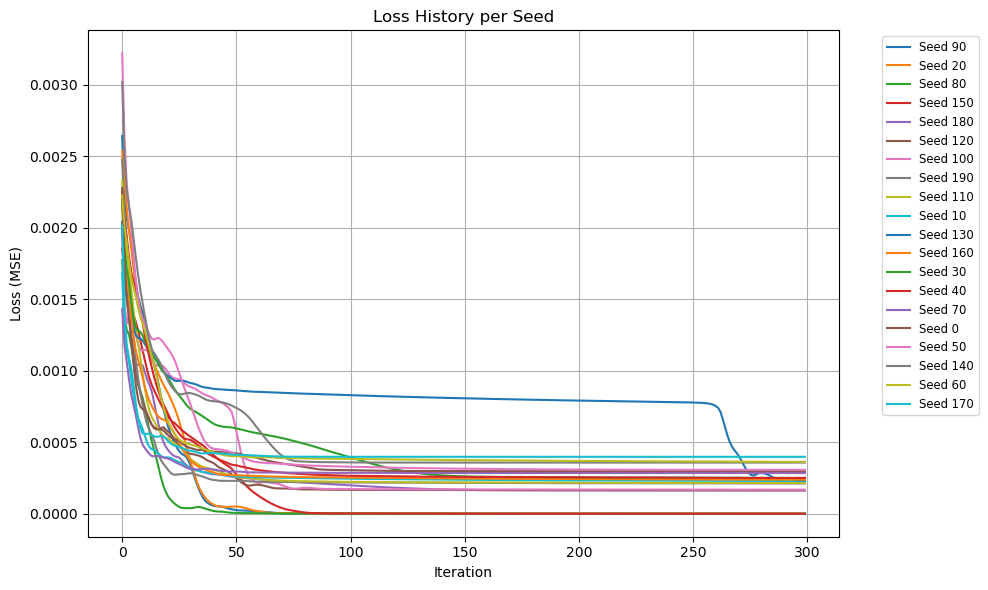

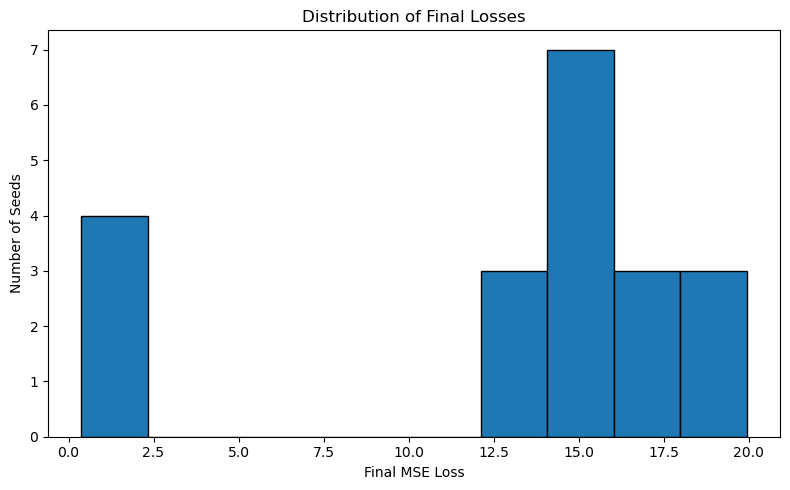

In [45]:
plt.figure(figsize=(10, 6))

for res in results_per_seed:
    plt.plot(res['loss history'], label=f"Seed {res['seed']}")

plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Loss History per Seed")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # move legend outside
plt.tight_layout()
plt.show()


## Histogram
losses = np.array([r['final_loss'] for r in results_per_seed])

plt.figure(figsize=(8, 5))
plt.hist(losses, bins=10, edgecolor='black')
plt.xlabel('Final MSE Loss')
plt.ylabel('Number of Seeds')
plt.title('Distribution of Final Losses')
plt.tight_layout()
plt.show()

Total number of groups: 5
Grouped indices: [[0, 1, 2], [3], [4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16], [17, 18, 19]]

✅ Reliable convergence after 1st TOA: 3 seeds (15.0%) within ±20% loss tolerance.

📏 Mean sensor position deviation for lowest group (std):
Along pipe length:         0.000762m
Around pipe circumference: 0.003453m

[One TOA] Average Loss: 0.38957 ± 0.01430 micro-seconds
[One TOA] Average v_group: 3030.5 ± 13.3m/s
[One TOA] Average t0: 0.00000545 ± 0.00000029 seconds or 22 ± 1 timesteps


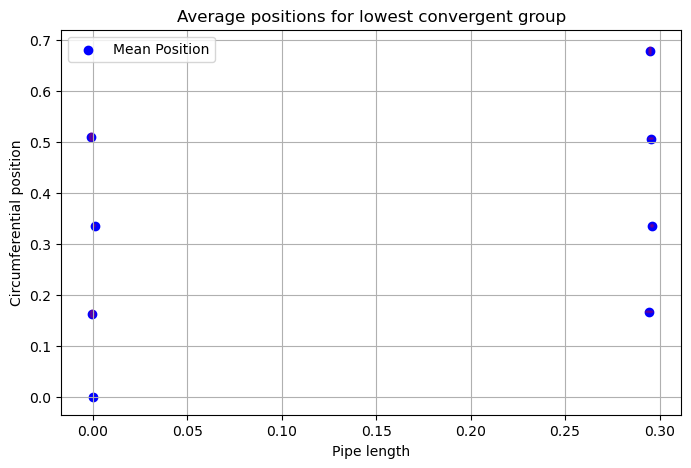

In [46]:
loss_tolerance_pct = 20   # Values within this percentage are grouped together  
reliability_threshold_pct = 15  # If more than 15% of initializations converge, method is reliable

# Grouping algorithm for similar losses
total = len(losses)
groups = []
used = np.zeros(total, dtype=bool)

for i in range(total):
    if used[i]:
        continue
    group = [i]
    for j in range(i+1, total):
        if not used[j] and abs((losses[j] - losses[i]) / losses[i]) <= (loss_tolerance_pct / 100):
            group.append(j)
            used[j] = True
    used[i] = True
    groups.append(group)
    
print(f'Total number of groups: {len(groups)}')
print(f'Grouped indices: {groups}')

# Check reliability based on first group
reliable = False
if len(groups) >= 1:
    first_group = groups[0]
    percent = (len(first_group) / total) * 100
    reliable = percent >= reliability_threshold_pct

if reliable:
    print(f"\n✅ Reliable convergence after 1st TOA: {len(first_group)} seeds ({percent:.1f}%) within ±{loss_tolerance_pct}% loss tolerance.")
else:
    print("\n❌ No reliable convergence found.")


group_0_results = [results_per_seed[i] for i in groups[0]]
best_result1 = results_per_seed[groups[0][0]]

# The average of all parameters in the lowest-loss group
average_loss = np.mean([res['final_loss'] for res in group_0_results])
std_loss = np.std([res['final_loss'] for res in group_0_results])

average_v_group = np.mean([res['v_group'] for res in group_0_results])
std_v_group = np.std([res['v_group'] for res in group_0_results])

average_t0 = np.mean([res['t0'] for res in group_0_results])
std_t0 = np.std([res['t0'] for res in group_0_results])

mean_std1, std_per_sensor1, mean_positions1 = compute_wrapped_std(groups[0], results_per_seed, pipe_circumference)


print(f"\n📏 Mean sensor position deviation for lowest group (std):")
print(f"Along pipe length:         {mean_std1[0]:.6f}m")
print(f"Around pipe circumference: {mean_std1[1]:.6f}m")

print(f"\n[One TOA] Average Loss: {average_loss:.5f} ± {std_loss:.5f} micro-seconds")
print(f"[One TOA] Average v_group: {average_v_group:.1f} ± {std_v_group:.1f}m/s")
print(f"[One TOA] Average t0: {average_t0:.8f} ± {std_t0:.8f} seconds "
      f"or {round(average_t0 * fs)} ± {round(std_t0 * fs)} timesteps")

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(mean_positions1[:, 0], mean_positions1[:, 1], c='blue', label='Mean Position')

for i in range(mean_positions1.shape[0]):
    ellipse = Ellipse(
        xy=mean_positions1[i],
        width=2 * std_per_sensor1[i, 0],
        height=2 * std_per_sensor1[i, 1],
        edgecolor='red',
        facecolor='red',
        alpha=0.25,        # Transparency
        lw=1.5
    )
    ax.add_patch(ellipse)
ax.set_xlabel("Pipe length")
ax.set_ylabel("Circumferential position")
ax.set_title('Average positions for lowest convergent group')
ax.grid(True)
ax.legend()

Under certian conditions the plot above may get too crowded. It denotes the sensor locations for the best convergence group.
If all(or many) initialization converge into the same group, change the loss_tolerance_pct. Set it to 0, if you wish to only view the
loss parameters.

### Optimizing for more helical paths

In [49]:
best_result = group_0_results[0]
distance_matrix = create_distance_matrix(points = best_result['positions'].clone().detach(), max_order = max_helical_order, pipe_dia = pipe_diameter)
new_time_zero = best_result['t0']
new_velocity = best_result['v_group']


simulated_toa = distance_matrix/new_velocity + new_time_zero
t = np.arange(len(data_df_corr_all)) / fs + new_time_zero
delta = 3*new_time_zero

In [50]:
sim_toa_np = simulated_toa.detach().numpy()
cwt_toas = np.full_like(sim_toa_np, np.nan)  # shape (8, 8, 4)
col_index = 0

for tx in range(total_sensors):
    for rx in range(total_sensors):
        signal = data_df_corr_all.iloc[:, col_index]

        cwt = make_cwt(signal, fs=fs, freq_range=freq_range, w=morlet_w,
                       plot_cwt=False, plot_dispertion=False, t0=-t0)
        
        magnitude = np.abs(cwt)
        mag_1d = magnitude[tx_freq_index, :]  

        sim_toas = sim_toa_np[tx, rx, :]  

        for i in range(max_helical_order):
            tmp = sim_toas[i]           
            point = int(tmp * fs)        
            win = int(delta * fs)
            start = max(0, point - win)
            end = min(len(mag_1d), point + win)

            
            if end > start:
                local_max_idx = mag_1d[start:end].argmax()
                global_idx = start + local_max_idx
                selected_time = t[global_idx]
                
                if global_idx == start or global_idx == end - 1:
                    cwt_toas[tx, rx, i] = np.nan
                else:
                    cwt_toas[tx, rx, i] = selected_time
            else:
                cwt_toas[tx, rx, i] = np.nan

        col_index += 1

cwt_toas = torch.from_numpy(cwt_toas)

In [51]:
col_index = 0
hilbert_toas = np.full_like(sim_toa_np, np.nan)

for tx in range(total_sensors):
    for rx in range(total_sensors):
        signal = data_df_corr_all.iloc[:, col_index].values
        filtered = sosfiltfilt(sos, signal)
        envelope = np.abs(hilbert(filtered))

        sim_toas = sim_toa_np[tx, rx, :] 

        for i in range(max_helical_order):
            tmp = sim_toas[i]           # time in seconds
            point = int(tmp * fs)       # sample index
            win = int(delta * fs)

            start = max(0, point - win)
            end = min(len(envelope), point + win)
            
            if end > start:
                local_max_idx = envelope[start:end].argmax()
                global_idx = start + local_max_idx
                selected_time = t[global_idx]
                
                if global_idx == start or global_idx == end - 1:
                    hilbert_toas[tx, rx, i] = np.nan
                else:
                    hilbert_toas[tx, rx, i] = selected_time
            else:
                hilbert_toas[tx, rx, i] = np.nan
        col_index += 1

hilbert_toas = torch.from_numpy(hilbert_toas)

### Plot figures:

Change the transmitter and receiver number below to view different signals. The horizontal line denotes the expected TOAs
for all helical paths. Note that in many cases, the lines overlap if the multiple path signals arrive at a sensor at the same time.

### Hilbert graph

Selected signal: ('Tx-Rx', 'V3RAUS1', 'V3RAUS3')


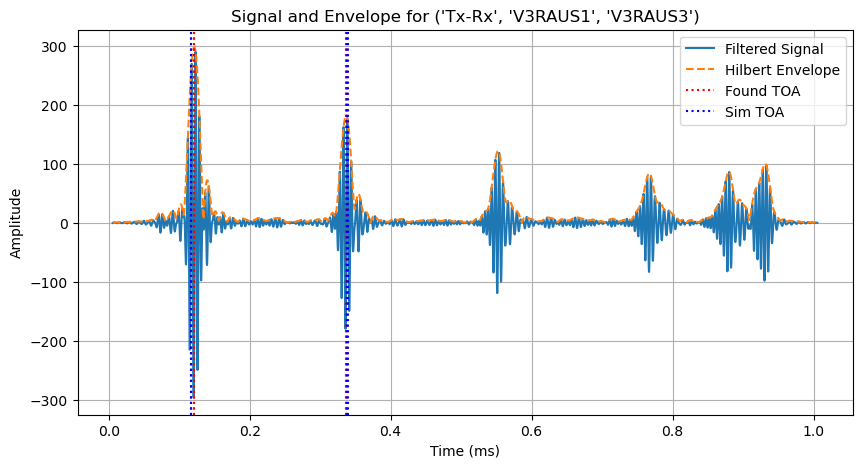

Peak envelope index: 463, time: 0.1214 ms
Simulated: 
TOA1: 0.1159974 TOA2: 0.1171105 TOA3: 0.3378366 TOA4: 0.3389497
Found:
TOA1: 0.1213837 TOA2: 0.1213837 TOA3: 0.3368837 TOA4: 0.3368837


In [55]:
### SHOULD BE BETWEEN 1 and max number of sensors. 
transmitter_no = 1
receiver_no = 3


row_idx = transmitter_no -1
col_idx = receiver_no -1

signal_index = total_sensors * row_idx + col_idx

signal_name = data_df_corr_all.columns[signal_index]
print("Selected signal:", signal_name)

filt = (tx_freq - 50e3, tx_freq + 50e3)
sos = butter(10, filt, btype='bandpass', fs=fs, output='sos')

raw_signal = data_df_corr_all[signal_name]
filtered_signal = sosfiltfilt(sos, raw_signal)
envelope = np.abs(hilbert(filtered_signal))

# time axis to milliseconds
t_ms = t * 1000

# Select TOAs from specific row and column of the matrix
toas_ms = hilbert_toas[row_idx, col_idx, :] * 1000  # to ms
simulated_toas_ms = simulated_toa[row_idx, col_idx, :] * 1000  # to ms

plt.figure(figsize=(10,5))
plt.plot(t_ms, filtered_signal, label='Filtered Signal')
plt.plot(t_ms, envelope, '--', label='Hilbert Envelope')

# Plot TOAs as vertical lines
for i, toa in enumerate(toas_ms):
    plt.axvline(x=toa, color='red', linestyle=':', label='Found TOA' if i == 0 else "")  # only label first one
for i, toa in enumerate(simulated_toas_ms):
    plt.axvline(x=toa, color='blue', linestyle=':', label='Sim TOA' if i == 0 else "")  # only label first one

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title(f'Signal and Envelope for {signal_name}')
plt.legend()
plt.grid(True)
plt.show()

# Print peak envelope
peak_idx = np.argmax(envelope)
print(f'Peak envelope index: {peak_idx}, time: {t[peak_idx] * 1000:.4f} ms')
print('Simulated: ')
print(*[f"TOA{idx+1}: {toa.item():.7f}" for idx, toa in enumerate(simulated_toas_ms)])
print('Found:')
print(*[f"TOA{idx+1}: {toa.item():.7f}" for idx, toa in enumerate(toas_ms)])

#### CWT graph

Selected signal: ('Tx-Rx', 'V3RAUS1', 'V3RAUS3')


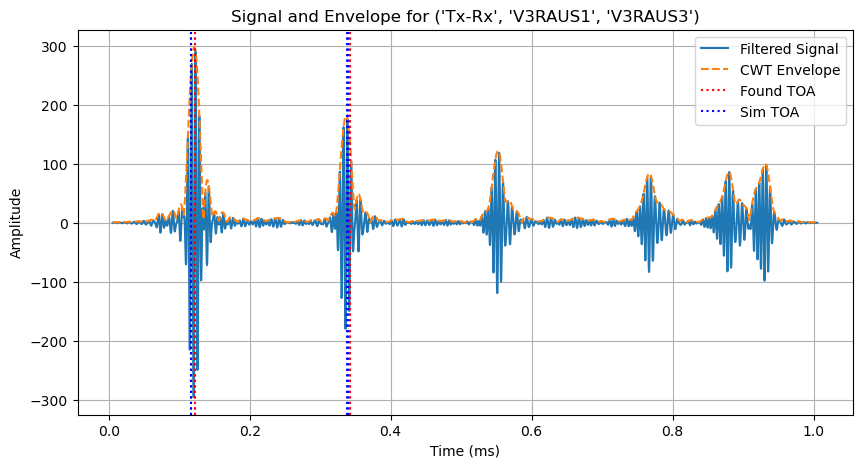

Peak envelope index: 463, time: 0.1214 ms
Simulated: 
TOA1: 0.1159974 TOA2: 0.1171105 TOA3: 0.3378366 TOA4: 0.3389497
Found:
TOA1: 0.1216337 TOA2: 0.1216337 TOA3: 0.3426337 TOA4: 0.3426337


In [57]:
### SHOULD BE BETWEEN 1 and max number of sensors. 
transmitter_no = 1
receiver_no = 3


row_idx = transmitter_no -1
col_idx = receiver_no -1

signal_index = total_sensors * row_idx + col_idx

signal_name = data_df_corr_all.columns[signal_index]
print("Selected signal:", signal_name)

filt = (tx_freq - 50e3, tx_freq + 50e3)
sos = butter(10, filt, btype='bandpass', fs=fs, output='sos')

raw_signal = data_df_corr_all[signal_name]
filtered_signal = sosfiltfilt(sos, raw_signal)

cwt = make_cwt(raw_signal, fs=fs, freq_range=freq_range, w=morlet_w,
               plot_cwt=False, plot_dispertion=False, t0=-t0)
magnitude = np.abs(cwt)
cwt_envelope = magnitude[tx_freq_index, :]

# time axis to milliseconds
t_ms = t * 1000

# Select TOAs from specific row and column of the matrix
toas_ms = cwt_toas[row_idx, col_idx, :] * 1000  # to ms
simulated_toas_ms = simulated_toa[row_idx, col_idx, :] * 1000  # to ms

plt.figure(figsize=(10,5))
plt.plot(t_ms, filtered_signal, label='Filtered Signal')
plt.plot(t_ms, envelope, '--', label='CWT Envelope')

# Plot TOAs as vertical lines
for i, toa in enumerate(toas_ms):
    plt.axvline(x=toa, color='red', linestyle=':', label='Found TOA' if i == 0 else "")  # only label first one
for i, toa in enumerate(simulated_toas_ms):
    plt.axvline(x=toa, color='blue', linestyle=':', label='Sim TOA' if i == 0 else "")  # only label first one

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title(f'Signal and Envelope for {signal_name}')
plt.legend()
plt.grid(True)
plt.show()

# Print peak envelope
peak_idx = np.argmax(envelope)
print(f'Peak envelope index: {peak_idx}, time: {t[peak_idx] * 1000:.4f} ms')
print('Simulated: ')
print(*[f"TOA{idx+1}: {toa.item():.7f}" for idx, toa in enumerate(simulated_toas_ms)])
print('Found:')
print(*[f"TOA{idx+1}: {toa.item():.7f}" for idx, toa in enumerate(toas_ms)])

In [58]:
final_mask_hilbert = torch.ones((total_sensors, total_sensors, max_helical_order), dtype=torch.bool)
final_mask_cwt = torch.ones((total_sensors, total_sensors, max_helical_order), dtype=torch.bool)

final_mask_hilbert[:, :, 0] = diagonal_mask 
final_mask_cwt[:, :, 0] = diagonal_mask 

nan_mask_hilbert = torch.isnan(hilbert_toas)
nan_mask_cwt = torch.isnan(cwt_toas)

final_mask_hilbert[nan_mask_hilbert] = False
final_mask_cwt[nan_mask_cwt] = False

### Optimizing for all helical paths

Only the seeds for the longest group in the previous 1 TOA optimization are taken here. This may be anywhere between 1 to
total number of initilizations.

In [61]:
top_10_results = results_per_seed[:10]
seeds = [res['seed'] for res in top_10_results]

In [62]:
new_experimental_toa = cwt_toas.float() * 1e3  
new_results_per_seed = []

for seed in seeds:
    torch.manual_seed(seed)
    sensor_positions = torch.rand((total_sensors, 2)).float()
    sensor_positions[:, 0] *= pipe_length
    sensor_positions[:, 1] *= pipe_circumference
    sensor_positions[0] = 0  # Anchor sensor 0

    new_points = sensor_positions.clone().requires_grad_(True)
    new_group_velocity = torch.tensor(A0_group_velocity_kms, dtype=torch.float32, requires_grad=True)
    new_t0 = torch.tensor(time_zero_ms, dtype=torch.float32, requires_grad=True)

    optimizer = torch.optim.Adam([new_points, new_group_velocity, new_t0], lr=0.01)
    new_loss_history = []

    for iteration in range(300):
        optimizer.zero_grad()
        distances = create_distance_matrix(new_points, max_order=max_helical_order, pipe_dia=pipe_diameter)
        simulated_toa = (distances / new_group_velocity) + new_t0
        new_loss = mse_loss(simulated_toa[final_mask_cwt], new_experimental_toa[final_mask_cwt])
        new_loss.backward()
        optimizer.step()

        new_loss_history.append(new_loss.item())

        with torch.no_grad():
            new_points.data[0] = torch.tensor([0.0, 0.0])

    with torch.no_grad():
        new_points.data[:, 1] %= pipe_circumference

    new_results_per_seed.append({
        'seed': seed,
        'final_loss': (new_loss.item() ** 0.5)*1e3,
        'positions': torch.abs(new_points.detach().clone()),
        'v_group': new_group_velocity.item() * 1e3,
        't0': new_t0.item() / 1e3,
        'loss history': new_loss_history
    })

    print(f"Seed {seed:>3} | Loss: {1e3 * new_loss.item()**0.5:.15f} | "
          f"v_group: {1e3 * new_group_velocity.item():.4f} | t0: {new_t0.item()/1e3:.6f}")

new_results_per_seed.sort(key=lambda x: x['final_loss'])

Seed  90 | Loss: 2.217897414760084 | v_group: 3058.4760 | t0: 0.000013
Seed  20 | Loss: 2.217783104612177 | v_group: 3058.4607 | t0: 0.000013
Seed  80 | Loss: 2.217778286028099 | v_group: 3058.4600 | t0: 0.000013
Seed 150 | Loss: 40.787138474957338 | v_group: 3293.7818 | t0: 0.000029
Seed 180 | Loss: 22.109877413005105 | v_group: 3138.1638 | t0: 0.000019
Seed 120 | Loss: 2.217901617980574 | v_group: 3058.4750 | t0: 0.000013
Seed 100 | Loss: 2.217902950707359 | v_group: 3058.4764 | t0: 0.000013
Seed 190 | Loss: 2.217779208736498 | v_group: 3058.4593 | t0: 0.000013
Seed 110 | Loss: 2.217776235563614 | v_group: 3058.4602 | t0: 0.000013
Seed  10 | Loss: 24.558554079346237 | v_group: 3124.6059 | t0: 0.000018


### Visualization for all helical path optimized data.

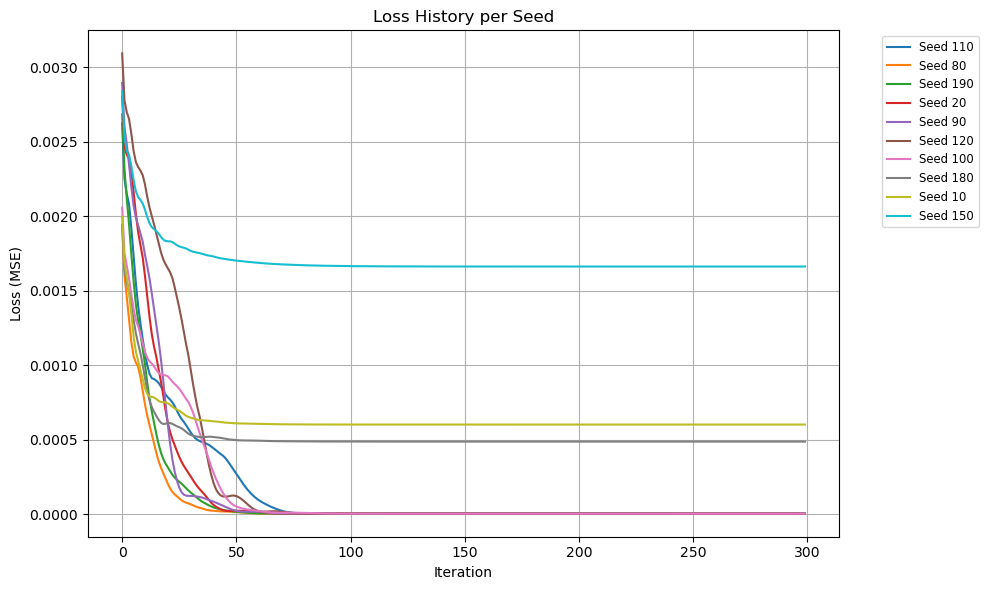

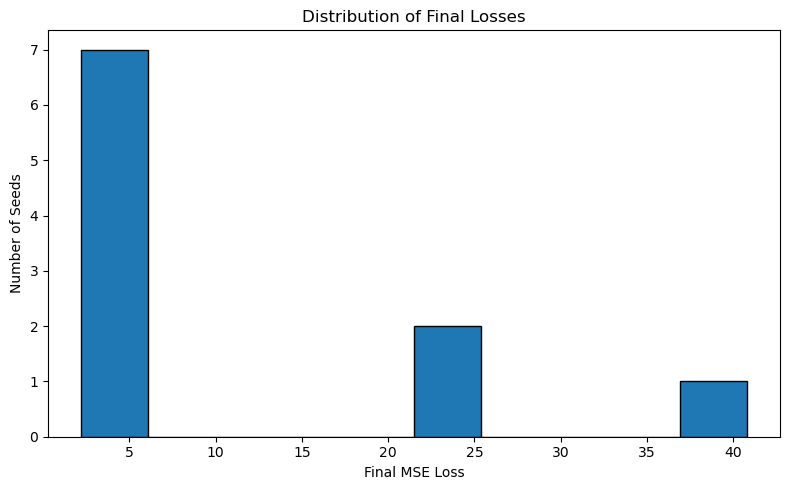

In [64]:
plt.figure(figsize=(10, 6))

for res in new_results_per_seed:
    plt.plot(res['loss history'], label=f"Seed {res['seed']}")

plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Loss History per Seed")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # move legend outside
plt.tight_layout()
plt.show()


## Histogram
new_losses = np.array([r['final_loss'] for r in new_results_per_seed])

plt.figure(figsize=(8, 5))
plt.hist(new_losses, bins= 10, edgecolor='black')
plt.xlabel('Final MSE Loss')
plt.ylabel('Number of Seeds')
plt.title('Distribution of Final Losses')
plt.tight_layout()
plt.show()


[New TOA] Group indices:
[[0, 1, 2, 3, 4, 5, 6], [7], [8], [9]]

✅ [New TOA] Reliable convergence: 7 seeds (70.0%) within ±10% loss tolerance.
Average positions:
[[0.         0.        ]
 [0.00134963 0.51381224]
 [0.00118383 0.337197  ]
 [0.0014321  0.16653991]
 [0.28927284 0.68435466]
 [0.28909373 0.50586706]
 [0.290283   0.3373792 ]
 [0.2894636  0.16811875]]

📏 Mean sensor position deviation for lowest group (std):
Along pipe length:         0.000394m
Around pipe circumference: 0.002867m

[All TOA] Average Loss: 2.21783 ± 0.00006 micro-seconds
[All TOA] Average v_group: 3058.5 ± 0.0 m/s
[All TOA] Average t0: 0.00001285 ± 0.00000000 seconds or 51 ± 0 timesteps


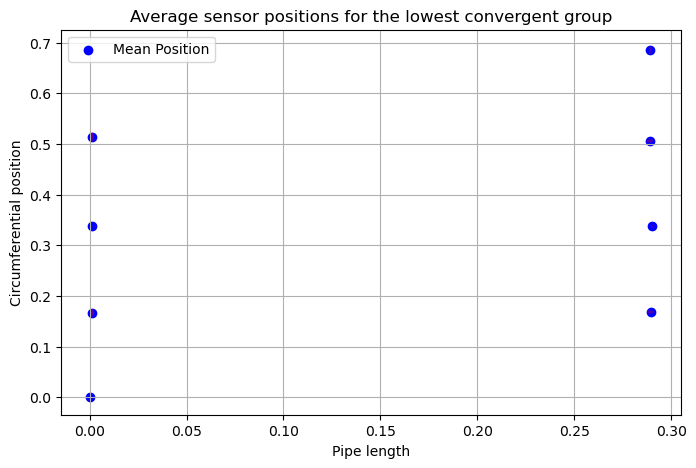

In [65]:
# Tolerance and reliability thresholds
loss_tolerance_pct = 10  # ±20% tolerance
reliability_threshold_pct = 15  


new_total = len(new_losses)
new_groups = []
used = np.zeros(new_total, dtype=bool)

# Grouping based on loss tolerance
for i in range(new_total):
    if used[i]:
        continue
    group = [i]
    for j in range(i + 1, new_total):
        if not used[j] and abs((new_losses[j] - new_losses[i]) / new_losses[i]) <= (loss_tolerance_pct / 100):
            group.append(j)
            used[j] = True
    used[i] = True
    new_groups.append(group)


print("\n[New TOA] Group indices:")
print(new_groups)


reliable = False
if len(new_groups) >= 1:
    first_group = new_groups[0]
    percent = (len(first_group) / new_total) * 100
    reliable = percent >= reliability_threshold_pct

# Print reliable convergence result
if reliable:
    print(f"\n✅ [New TOA] Reliable convergence: {len(first_group)} seeds ({percent:.1f}%) within ±{loss_tolerance_pct}% loss tolerance.")
else:
    print("\n❌ [New TOA] No reliable convergence found.")



# Lowest-loss group results
new_group_0_results = [new_results_per_seed[i] for i in new_groups[0]]
best_result2 = new_results_per_seed[groups[0][0]]

# Average of all parameters in the lowest-loss group
new_average_loss = np.mean([res['final_loss'] for res in new_group_0_results])
new_std_loss = np.std([res['final_loss'] for res in new_group_0_results])

new_average_v_group = np.mean([res['v_group'] for res in new_group_0_results])
new_std_v_group = np.std([res['v_group'] for res in new_group_0_results])

new_average_t0 = np.mean([res['t0'] for res in new_group_0_results])
new_std_t0 = np.std([res['t0'] for res in new_group_0_results])

mean_std2, std_per_sensor2, mean_positions2 = compute_wrapped_std(new_groups[0], new_results_per_seed, pipe_circumference)

print("Average positions:")
print(mean_positions2)

print(f"\n📏 Mean sensor position deviation for lowest group (std):")
print(f"Along pipe length:         {mean_std2[0]:.6f}m")
print(f"Around pipe circumference: {mean_std2[1]:.6f}m")

print(f"\n[All TOA] Average Loss: {new_average_loss:.5f} ± {new_std_loss:.5f} micro-seconds")
print(f"[All TOA] Average v_group: {new_average_v_group:.1f} ± {new_std_v_group:.1f} m/s")
print(f"[All TOA] Average t0: {new_average_t0:.8f} ± {new_std_t0:.8f} seconds "
      f"or {round(new_average_t0 * fs)} ± {round(new_std_t0 * fs)} timesteps")


fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(mean_positions2[:, 0], mean_positions2[:, 1], c='blue', label='Mean Position')

for i in range(mean_positions2.shape[0]):
    ellipse = Ellipse(
        xy=mean_positions2[i],
        width=2 * std_per_sensor2[i, 0],
        height=2 * std_per_sensor2[i, 1],
        edgecolor='red',
        facecolor='red',
        alpha=0.25,        # Transparency
        lw=1.5
    )
    ax.add_patch(ellipse)

ax.set_xlabel("Pipe length")
ax.set_ylabel("Circumferential position")
ax.set_title('Average sensor positions for the lowest convergent group')
ax.grid(True)
ax.legend()


## Final optimized parameters.

Final parameters (1st TOA):

Best positions:
[[ 0.     0.   ]
 [-0.002  0.504]
 [ 0.001  0.335]
 [ 0.001  0.154]
 [ 0.295  0.001]
 [ 0.297  0.508]
 [ 0.296  0.335]
 [ 0.294  0.169]]
Final loss: 0.37863 micro-seconds
v_group: 3039.1 m/s
t0: 0.00000563 seconds or 23 timesteps


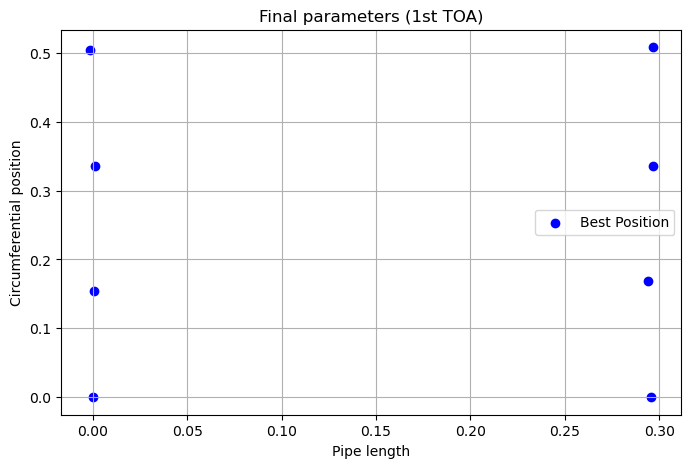

In [67]:
title1 = 'Final parameters (1st TOA)'

best_positions1 = best_result1['positions'].detach().numpy()


print(f"{title1}:\n")
print("Best positions:")
print(np.round(best_positions1, 3))
print(f"Final loss: {best_result1['final_loss']:.5f} micro-seconds")
print(f"v_group: {best_result1['v_group']:.1f} m/s")
print(f"t0: {best_result1['t0']:.8f} seconds or {round(best_result1['t0'] * fs)} timesteps")


fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(best_positions1[:, 0], best_positions1[:, 1], c='blue', label='Best Position')


ax.set_xlabel("Pipe length")
ax.set_ylabel("Circumferential position")
ax.set_title(title1)
ax.grid(True)
ax.legend()

Final Parameters (All TOAs):

Best positions:
[[0.    0.   ]
 [0.002 0.506]
 [0.001 0.337]
 [0.001 0.169]
 [0.289 0.001]
 [0.291 0.507]
 [0.29  0.336]
 [0.288 0.169]]
Final loss: 2.21778 micro-seconds
v_group: 3058.5 m/s
t0: 0.00001285 seconds or 51 timesteps


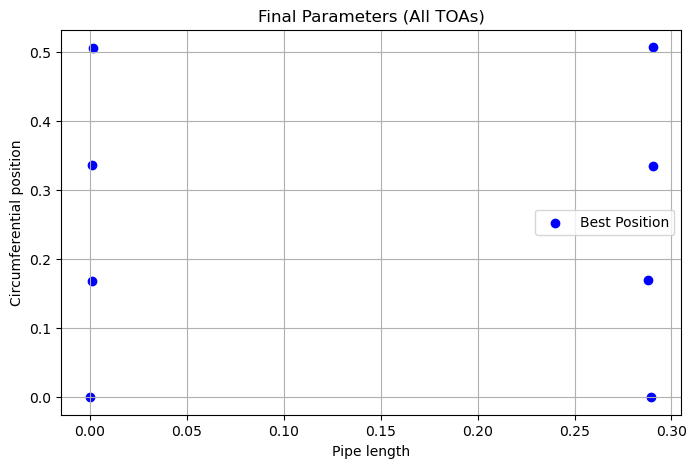

In [68]:
title2 = 'Final Parameters (All TOAs)'

best_positions2 = best_result2['positions'].detach().numpy()


print(f"{title2}:\n")
print("Best positions:")
print(np.round(best_positions2, 3))
print(f"Final loss: {best_result2['final_loss']:.5f} micro-seconds")
print(f"v_group: {best_result2['v_group']:.1f} m/s")
print(f"t0: {best_result2['t0']:.8f} seconds or {round(best_result2['t0'] * fs)} timesteps")


fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(best_positions2[:, 0], best_positions2[:, 1], c='blue', label='Best Position')


ax.set_xlabel("Pipe length")
ax.set_ylabel("Circumferential position")
ax.set_title(title2)
ax.grid(True)
ax.legend()